# Save the dataset into variable

In [1]:
import pandas as pd

file = pd.read_csv('spam.csv', encoding='latin1')
file.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Check wether the dataset contains missing value or not

In [2]:
file.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

# Retrieve only usefull columns

In [3]:
X = file['v2']
y = file['v1']

# Data Pre-Processing (Ubah teks menjadi kumpulan kata sederhana yang dapat di pahami komputer) menggunakan tokenization

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('stopwords')

stemmer = PorterStemmer()
lemma = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()  # Ubah ke huruf kecil
    text = re.sub(r'\W', ' ', text)  # Hapus tanda baca
    text = re.sub(r'\s+', ' ', text)  # Hapus spasi berlebih
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = ' '.join([lemma.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Terapkan preprocessing ke semua teks
X_cleaned = X.apply(preprocess)

print(X_cleaned)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry wkly comp win fa cup final tkts st ...
3                     u dun say early hor u c already say
4                     nah think go usf life around though
                              ...                        
5567    nd time tried contact u u pound prize claim ea...
5568                            b going esplanade fr home
5569                                 pity mood suggestion
5570    guy bitching acted like interested buying some...
5571                                       rofl true name
Name: v2, Length: 5572, dtype: object


# Ubah text menjadi vektor numerik dengan menggunakan TF-IDF (Term Frequency-Inverse Document Frequency)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  # Ambil 5000 kata paling umum
X_vectorize = vectorizer.fit_transform(X).toarray()

print("Shape of feature matrix:", X_vectorize.shape)


Shape of feature matrix: (5572, 5000)


# Bagi data menjadi train dan test untuk validasi ketepatan model dalam prediksi

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vectorize, y, test_size=0.2, random_state=42)

print(f"Training size: {X_train.shape}, Testing size: {X_test.shape}")


Training size: (4457, 5000), Testing size: (1115, 5000)


# Melatih Model dengan Stacking Model

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

from sklearn.metrics import accuracy_score, classification_report

# Buat model Naïve Bayes
nb_model = GaussianNB()

# Buat model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Buat model decision
model_dec = RandomForestClassifier(n_estimators=100, random_state=42)

model = StackingClassifier(
    estimators=[('naive_bayes', nb_model), ('random_forest', rf_model)],
    final_estimator=model_dec  # Using Random Forest as final decision
)

model.fit(X_train, y_train)

# Prediksi pada data uji
y_pred = model.predict(X_test)

# Evaluasi model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9874439461883409
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       965
        spam       0.97      0.94      0.95       150

    accuracy                           0.99      1115
   macro avg       0.98      0.97      0.97      1115
weighted avg       0.99      0.99      0.99      1115



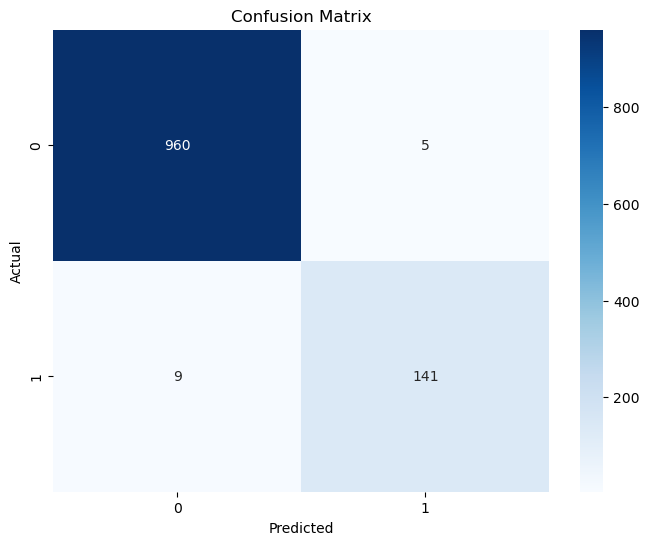

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

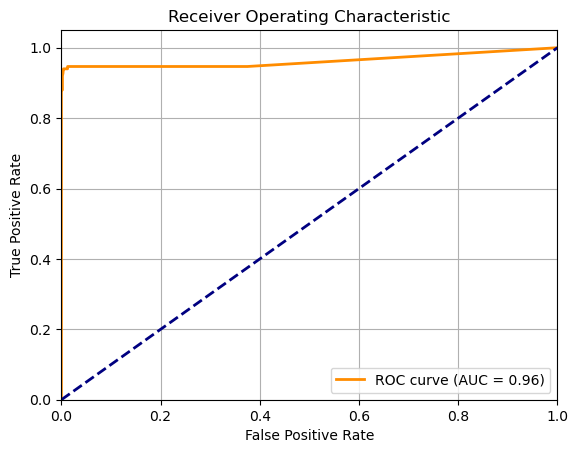

In [11]:
from sklearn.metrics import roc_curve, auc

y_score = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label='spam')
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Save the model

In [ ]:
import joblib

# Simpan model dan vectorizer
joblib.dump(model, "spam_classifier.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("Model berhasil disimpan!")

Model berhasil disimpan!


# Testing / Evaluation

In [ ]:
def predict_email(email, model, vectorizer):
    email_clean = preprocess(email)
    email_vectorized = vectorizer.transform([email_clean]).toarray()
    prediction = model.predict(email_vectorized)[0]
    return prediction

file = open('spam_classifier.pkl', 'rb')
model = joblib.load(file)
file.close()

file=open('tfidf_vectorizer.pkl', 'rb')
vectorizer = joblib.load(file)
file.close()

email_sample = "get this for free!"
print(predict_email(email_sample, model, vectorizer))  # Harusnya "Spam"


spam
